In [2]:
pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 1.3MB/s 
     |████████████████████████████████| 491kB 35.2MB/s 
     |████████████████████████████████| 3.2MB 36.6MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [1]:
import os
import sys
import random
import warnings
import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import AveragePooling2D, BatchNormalization, ELU, Reshape, Concatenate, Activation
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

# Set some parameters
IMG_WIDTH = 152
IMG_HEIGHT = 60
IMG_CHANNELS = 3

TRAIN_PATH='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/x_train_new/'
TEST_PATH ='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/x_test_new/'
MASK_TRAIN='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/y_train_new/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf

In [3]:
tf.version

<module 'tensorflow._api.v1.compat.v1.version' from 'C:\\Users\\jmlee\\anaconda3\\lib\\site-packages\\tensorflow\\_api\\v1\\compat\\v1\\version\\__init__.py'>

In [4]:
# #한글이름 사진 로드
from PIL import Image

#gray로 불러와야 threshold  함수 사용가능
def hangulFilePathImageRead2 (filePath ) :  
    stream = open( filePath.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

In [7]:
train_path=os.walk(TRAIN_PATH) #raw
train_ids= next(train_path)[2]

test_path=os.walk(TEST_PATH)
test_ids = next(test_path)[2]

mask_path=os.walk(MASK_TRAIN)
mask_ids = next(mask_path)[2]

In [8]:
test_ids.sort()
train_ids.sort()
mask_ids.sort()

In [9]:
len(train_ids)

1880

In [10]:
len(test_ids)

600

In [11]:
len(mask_ids)

1880

In [10]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_PATH+id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    train_= hangulFilePathImageRead2(MASK_TRAIN+id_)
    mask_=cv2.adaptiveThreshold(train_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,15, 11) 
    mask_= np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    #mask = np.maximum(mask, mask_)
    Y_train[n] = mask_
    

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH+id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|█████████████████████████████████████████████████████████████████████████████| 1880/1880 [00:09<00:00, 201.87it/s]

Getting and resizing test images ... 



100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 78.69it/s]

Done!


In [11]:
print(Y_train.shape)
print(X_train.shape)
print(X_test.shape)
#print(mask_.shape)
#print(test_.shape)

(1880, 60, 152, 1)
(1880, 60, 152, 3)
(600, 60, 152, 3)


802


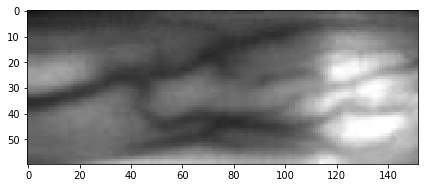

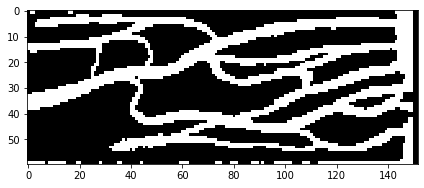

In [12]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
print(ix)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [13]:
# Define IoU metric
# #tf.dtypes.cast(x, tf.int32)
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred= tf.dtypes.cast(y_pred, tf.int32)
#         y_pred_ = y_pred > t
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

# Define IoU metric_new
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [14]:
# densenet 모델을 위한 함수
def _bn_relu_conv(x, growth_rate, dropout_rate=None, weight_decay=1E-4):
    x = BatchNormalization(axis=-1, gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(growth_rate, (3, 3), kernel_initializer='he_normal', padding="same", use_bias=False,
               kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

def transition(x, nb_filter, dropout_rate=None, weight_decay=1E-4, pooling=True):
    x = BatchNormalization(axis=-1, gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (1, 1), kernel_initializer='he_normal', padding="same", use_bias=False,
               kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    if pooling:
        x = AveragePooling2D(pool_size=(2, 2))(x)
    return x

def denseblock(x, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1E-4):
    for i in range(nb_layers):
        merge_tensor = _bn_relu_conv(x, growth_rate, dropout_rate, weight_decay)
        x = Concatenate(axis=-1)([merge_tensor, x])
        nb_filter += growth_rate
    return x, nb_filter

In [15]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

In [16]:
from tensorflow.python.keras.metrics import Metric
from keras import metrics

nb_filter = 6
growth_rate = 12
dropout_rate = 0.5
weight_decay = 1e-4

# Build U-Net model
inputs = Input((60, 152, 3))
s = Lambda(lambda x: x / 255) (inputs)
print(s)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization(axis=3, momentum=0.99)(c1) # Tensorflow uses filter format [filter_height, filter_width, in_channels, out_channels], hence axis = 3
c1 = ELU()(c1)
dense1, nb_filter = denseblock(c1, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense1 = transition(dense1, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
p1 = AveragePooling2D(pool_size=(2, 2))(dense1)
print("p1",p1)
c1_filter = nb_filter

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization(axis=3, momentum=0.99)(c2) # Tensorflow uses filter format [filter_height, filter_width, in_channels, out_channels], hence axis = 3
c2 = ELU()(c2)
dense2, nb_filter = denseblock(c2, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense2 = transition(dense2, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense2, nb_filter = denseblock(dense2, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense2 = transition(dense2, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
print("c2",dense2)
c2_filter = nb_filter

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (dense2)
dense3, nb_filter = denseblock(c3, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense3 = transition(dense3, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense3, nb_filter = denseblock(dense3, 6, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense3 = transition(dense3, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
p3 = AveragePooling2D(pool_size=(2, 2))(dense3)
print("p3",p3)
c3_filter = nb_filter

dense4, nb_filter = denseblock(p3, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense4 = transition(dense4, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense4, nb_filter = denseblock(dense4, 6, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense4 = transition(dense4, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense4, _ = denseblock(dense4, 6, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense4 = transition(dense4, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense4, _ = denseblock(dense4, 3, nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense4 = transition(dense4, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
print("mid", dense4)

u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (dense4)
u5 = concatenate([u5, dense3])
dense5, _ = denseblock(u5, 6, c3_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense5 = transition(dense5, c3_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense5, _ = denseblock(dense5, 3, c3_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense5 = transition(dense5, c3_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
print("u5",dense5)

c6 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (dense5)
dense6, _ = denseblock(c6, 3, c2_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense6 = transition(dense6, c2_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
dense6, _ = denseblock(dense6, 3, c2_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense6 = transition(dense6, c2_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
print("c6",dense6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (dense6)
u7 = concatenate([u7, dense1])
dense7, _ = denseblock(u7, 3, c1_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)
dense7 = transition(dense7, c1_filter, dropout_rate=dropout_rate, weight_decay=weight_decay, pooling=False)
print("u7",dense7)

outputs = Conv2D(64, (1, 1), activation='sigmoid') (dense7)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (outputs)
print("outputs",outputs)
#mIOU = tf.keras.metrics.MeanIoU(num_classes=20)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Tensor("lambda_2/truediv:0", shape=(?, 60, 152, 3), dtype=float32)

p1 Tensor("average_pooling2d_1/AvgPool:0", shape=(?, 30, 76, 42), dtype=float32)
c2 Tensor("dropout_12/cond/Merge:0", shape=(?, 30, 76, 114), dtype=float32)
p3 Tensor("average_pooling2d_2/AvgPool:0", shape=(?, 15, 38, 222), dtype=float32)
mid Tensor("dropout_45/cond/Merge:0", shape=(?, 15, 38, 330), dtype=float32)
u5 Tensor("dropout_56/cond/Merge:0", shape=(?, 30, 76, 222), dtype=float32)
c6 Tensor("dropout_64/cond/Merge:0", shape=(?, 30, 76, 114), dtype=float32)
u7 Tensor("dropout_68/cond/Merge:0", shape=(?, 60, 152, 42), dtype=float32)
outputs Tensor("conv2d_74/Sigmoid:0", shape=(?, 60, 152, 1), dtype=float32)
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
_________________________________________________________________________

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=12, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=30, epochs=30, callbacks=[earlystopper, checkpointer])


Train on 1692 samples, validate on 188 samples
Epoch 1/30
 480/1692 [=======>......................] - ETA: 2:18:19 - loss: 2.6093 - mean_iou: 0.0323

In [21]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.4).astype(np.uint8)
preds_val_t = (preds_val > 0.4).astype(np.uint8)
preds_test_t = (preds_test > 0.4).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

600/600 [==============================] - 34s 56ms/step


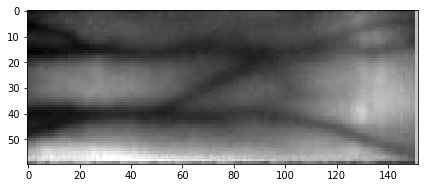

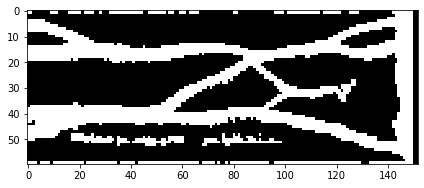

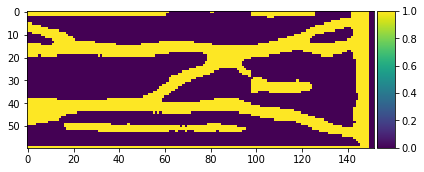

In [22]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

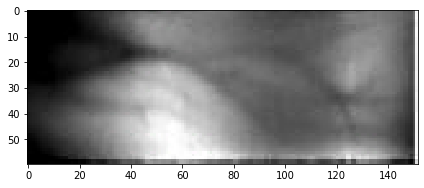

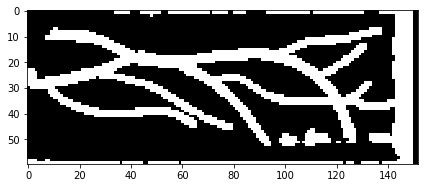

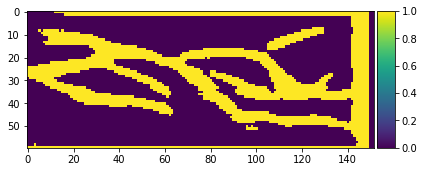

In [23]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

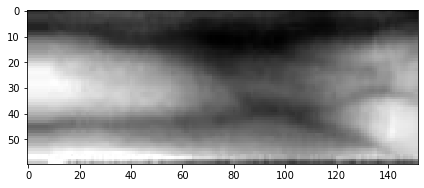

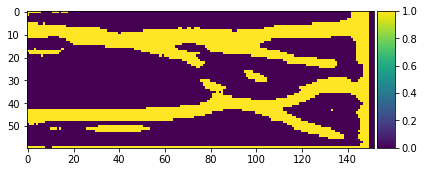

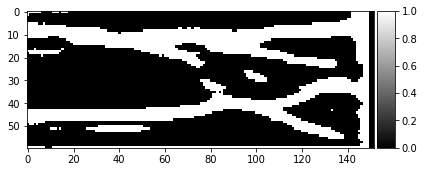

In [24]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
# imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
# plt.show()
a= np.squeeze(preds_test_t[ix])
imshow(np.squeeze(preds_test_t[ix]))
plt.show()
imshow(a,cmap='gray')
plt.show()

In [25]:
import scipy
from scipy import ndimage

b= np.array(X_test[ix])
print(X_test[ix].shape)
a=np.squeeze(preds_test_t[ix])
lowpass = ndimage.gaussian_filter(X_test[ix], 3)
X_test[ix] = X_test[ix][:,:,0]
print(lowpass.shape)
# a = np.expand_dims(resize(a, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
new_img = b+ a

imshow(new_img)


(60, 152, 3)


ValueError: ignored

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('drive/My Drive/Colab Notebooks/UNET/data_files/sub-dsbowl2018-1.csv', index=False)